#**Step1: PreProcessing**

In [ ]:
import os
import librosa
import numpy as np
import soundfile as sf

def normalize_and_adjust_length(audio_path, output_path, target_sr=44100, duration=60):

    # Loading and resampling the audio file
    audio, sr = librosa.load(audio_path, sr=target_sr)

    # Calculating the target length in samples
    target_length = target_sr * duration

    # For Adjusting the length of the audio
    if len(audio) < target_length:
        audio = np.pad(audio, (0, target_length - len(audio)), 'constant')
    else:
        audio = audio[:target_length]

    # Findng the peak amplitude of the audio signal
    peak = np.max(np.abs(audio))

    # Normalizing the audio signal by the peak amplitude
    normalized_audio = audio / peak

    # Save the normalized, resampled, and length-adjusted audio file
    sf.write(output_path, normalized_audio, target_sr)

    print(f"File normalized, resampled to {target_sr} Hz, and adjusted to {duration} seconds, saved at {output_path}")

def batch_process_audio_files(input_folder, output_folder, target_sr=44100, duration=60):

    # Create the output folder if it does not exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Process each file in the input folder
    for filename in os.listdir(input_folder):
        if filename.endswith(".wav"):
            input_path = os.path.join(input_folder, filename)
            output_path = os.path.join(output_folder, filename)
            normalize_and_adjust_length(input_path, output_path, target_sr, duration)

# Example usage
input_folder = '/content/sample_data/Raw_data'
output_folder = '/content/sample_data/PreProcessed_data'
batch_process_audio_files(input_folder, output_folder, 44100, 60)

File normalized, resampled to 44100 Hz, and adjusted to 60 seconds, saved at /content/sample_data/PreProcessed_data/num29.wav
File normalized, resampled to 44100 Hz, and adjusted to 60 seconds, saved at /content/sample_data/PreProcessed_data/num81.wav
File normalized, resampled to 44100 Hz, and adjusted to 60 seconds, saved at /content/sample_data/PreProcessed_data/num44.wav
File normalized, resampled to 44100 Hz, and adjusted to 60 seconds, saved at /content/sample_data/PreProcessed_data/num14.wav
File normalized, resampled to 44100 Hz, and adjusted to 60 seconds, saved at /content/sample_data/PreProcessed_data/num32.wav
File normalized, resampled to 44100 Hz, and adjusted to 60 seconds, saved at /content/sample_data/PreProcessed_data/num53.wav
File normalized, resampled to 44100 Hz, and adjusted to 60 seconds, saved at /content/sample_data/PreProcessed_data/num108.wav
File normalized, resampled to 44100 Hz, and adjusted to 60 seconds, saved at /content/sample_data/PreProcessed_data/n

#**Step2: Feature Extraction**

In [ ]:
import librosa
import numpy as np
import pandas as pd
import os

# Setting for MFCC
num_mfcc = 13  # Number of MFCC coefficients
frame_length = 0.025  # Window length (25ms)
hop_length = 0.010    # length of overlapping (10ms)

# The path of folder
audio_folder_path = '/content/sample_data/PreProcessed_data'

# Creating a DataFrame for extracted features
df_features = pd.DataFrame()

# Segmentation of audio files
def divide_audio_to_segments(audio, sr, segment_count=3):
    total_frames = librosa.get_duration(y=audio, sr=sr) / hop_length
    segment_length = total_frames // segment_count

    summary_features = {}

    for i in range(segment_count):
        start_frame = int(i * segment_length * sr * hop_length)
        end_frame = int((i + 1) * segment_length * sr * hop_length)
        segment = audio[start_frame:end_frame]

        # Extract MFCC and their derivatives for the segment
        mfccs_segment = librosa.feature.mfcc(y=segment, sr=sr, n_mfcc=num_mfcc)
        delta_segment = librosa.feature.delta(mfccs_segment)
        delta2_segment = librosa.feature.delta(mfccs_segment, order=2)

        #Calculating Mean and Std for each of them
        for j in range(num_mfcc):
            summary_features[f'Segment_{i+1}_MFCC_{j+1}_mean'] = np.mean(mfccs_segment[j])
            summary_features[f'Segment_{i+1}_MFCC_{j+1}_std'] = np.std(mfccs_segment[j])
            summary_features[f'Segment_{i+1}_Delta_MFCC_{j+1}_mean'] = np.mean(delta_segment[j])
            summary_features[f'Segment_{i+1}_Delta_MFCC_{j+1}_std'] = np.std(delta_segment[j])
            summary_features[f'Segment_{i+1}_Delta2_MFCC_{j+1}_mean'] = np.mean(delta2_segment[j])
            summary_features[f'Segment_{i+1}_Delta2_MFCC_{j+1}_std'] = np.std(delta2_segment[j])

    return summary_features

# Process of extraction for each audio file
for file_name in os.listdir(audio_folder_path):
    if file_name.endswith('.wav'):
        file_path = os.path.join(audio_folder_path, file_name)

        # Load the audio file
        audio, sr = librosa.load(file_path, sr=None)

        # Convert frame length and overlap to samples.
        frame_length_samples = int(frame_length * sr)
        hop_length_samples = int(hop_length * sr)

        # Extract overall MFCC and their derivatives
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=num_mfcc, hop_length=hop_length_samples, n_fft=frame_length_samples)
        delta_mfccs = librosa.feature.delta(mfccs)
        delta2_mfccs = librosa.feature.delta(mfccs, order=2)

        # Calculate mean and std for each coefficient and its derivatives
        mfccs_mean = np.mean(mfccs, axis=1)
        mfccs_std = np.std(mfccs, axis=1)
        delta_mfccs_mean = np.mean(delta_mfccs, axis=1)
        delta_mfccs_std = np.std(delta_mfccs, axis=1)
        delta2_mfccs_mean = np.mean(delta2_mfccs, axis=1)
        delta2_mfccs_std = np.std(delta2_mfccs, axis=1)

        # Create dictionary for overall features
        features = {'FileName': file_name}

        # Add MFCC means and stds
        for i in range(num_mfcc):
            features[f'MFCC_{i+1}_mean'] = mfccs_mean[i]
            features[f'MFCC_{i+1}_std'] = mfccs_std[i]
            features[f'Delta_MFCC_{i+1}_mean'] = delta_mfccs_mean[i]
            features[f'Delta_MFCC_{i+1}_std'] = delta_mfccs_std[i]
            features[f'Delta2_MFCC_{i+1}_mean'] = delta2_mfccs_mean[i]
            features[f'Delta2_MFCC_{i+1}_std'] = delta2_mfccs_std[i]

        # Summarization of segments (beginning, middle, end)
        segment_features = divide_audio_to_segments(audio, sr)
        features.update(segment_features)

        # Append features to DataFrame
        df_features = pd.concat([df_features, pd.DataFrame([features])], ignore_index=True)

# Save to CSV
output_csv_path = '/content/sample_data/output_features_combine_delta.csv'
df_features.to_csv(output_csv_path, index=False)

#**Step3: Statistical Analysis**

In [ ]:
import pandas as pd

df_features = pd.read_csv('/content/sample_data/output_features_combine_delta.csv')


print(df_features.head())
print(df_features.tail())

    FileName  MFCC_1_mean  MFCC_1_std  Delta_MFCC_1_mean  Delta_MFCC_1_std  \
0  num29.wav   -409.04670  106.650820           0.064885         15.737716   
1  num81.wav   -472.09190   81.198590           0.005187          7.361934   
2  num44.wav   -392.83624  114.735200           0.001236         17.582365   
3  num14.wav   -374.97340   34.941605          -0.025665          3.254188   
4  num32.wav   -425.16110   40.819775           0.062061          3.115016   

   Delta2_MFCC_1_mean  Delta2_MFCC_1_std  MFCC_2_mean  MFCC_2_std  \
0           -0.000115           7.395443    80.156586   44.533630   
1            0.001882           2.882272    87.292076   32.866745   
2            0.000445           7.101242    74.277054   43.289074   
3           -0.001131           1.341365   133.760730   16.987335   
4           -0.012589           1.719743    96.486984   14.324634   

   Delta_MFCC_2_mean  ...  Segment_3_Delta_MFCC_12_mean  \
0           0.020606  ...                     -0.013495  

In [ ]:
print(df_features.describe())

NameError: name 'df_features' is not defined

In [ ]:
print(df_features.isnull().sum())

FileName                         0
MFCC_1_mean                      0
MFCC_1_std                       0
Delta_MFCC_1_mean                0
Delta_MFCC_1_std                 0
                                ..
Segment_3_MFCC_13_std            0
Segment_3_Delta_MFCC_13_mean     0
Segment_3_Delta_MFCC_13_std      0
Segment_3_Delta2_MFCC_13_mean    0
Segment_3_Delta2_MFCC_13_std     0
Length: 313, dtype: int64


In [ ]:
import pandas as pd


print(df_features.shape)

(126, 313)


In [ ]:
df_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Columns: 313 entries, FileName to Segment_3_Delta2_MFCC_13_std
dtypes: float64(312), object(1)
memory usage: 308.2+ KB


**Merge by Labels**

In [ ]:
import pandas as pd


features_path = '/content/sample_data/output_features_combine_delta.csv'
df_features = pd.read_csv(features_path)

labels_path = '/content/sample_data/FinalFiles.xlsx'
df_labels = pd.read_excel(labels_path)

# merge according same column
df_combined = pd.merge(df_features, df_labels, left_on='FileName', right_on='FileName')

# save merge DataFrame in csv format
df_combined.to_csv('/content/sample_data/merge_feature_label_data.csv', index=False)

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt

# Deleted FileName in this file
df = pd.read_csv('/content/sample_data/data_statistic_test.csv')

# Define two groups according Labels
group1 = df[df['label'] == 0]  # G1
group2 = df[df['label'] == 1]  # G2

# Assume the last column is for label
feature_columns = df.columns[:-1]

# Create a DataFrame for saving T-Test result
results = pd.DataFrame()

for feature in feature_columns:
    # Run for Each Feature
    t_stat, p_val = ttest_ind(group1[feature], group2[feature], equal_var=False, nan_policy='omit')
    result_df = pd.DataFrame({'Feature': [feature], 'T-Statistic': [t_stat], 'P-Value': [p_val]})
    results = pd.concat([results, result_df], ignore_index=True)

# Order the results according P-Value
sorted_results = results.sort_values(by='P-Value', ascending=True)

# Print 20 features that they have best results
print(sorted_results.iloc[:20])


                         Feature  T-Statistic       P-Value
249   Segment_3_Delta_MFCC_3_std    -8.748186  1.305913e-14
239  Segment_3_Delta2_MFCC_1_std    -8.646256  4.840413e-14
237   Segment_3_Delta_MFCC_1_std    -8.192289  3.175528e-13
251  Segment_3_Delta2_MFCC_3_std    -8.171799  3.345078e-13
15              Delta_MFCC_3_std    -7.499182  1.071825e-11
289        Segment_3_MFCC_10_std    -7.488342  1.169819e-11
261   Segment_3_Delta_MFCC_5_std    -7.462242  1.593054e-11
5              Delta2_MFCC_1_std    -7.487594  1.702700e-11
263  Segment_3_Delta2_MFCC_5_std    -7.303057  4.171900e-11
247         Segment_3_MFCC_3_std    -7.159615  1.250040e-10
17             Delta2_MFCC_3_std    -6.933536  2.138197e-10
279   Segment_3_Delta_MFCC_8_std    -6.864751  2.834625e-10
269  Segment_3_Delta2_MFCC_6_std    -6.842052  3.197974e-10
307        Segment_3_MFCC_13_std    -6.800380  4.283533e-10
285   Segment_3_Delta_MFCC_9_std    -6.773853  4.494799e-10
287  Segment_3_Delta2_MFCC_9_std    -6.7

**Resolve imbalancing**
Combining Oversampling or Undersampling

In [ ]:
from imblearn.combine import SMOTETomek
import pandas as pd
from collections import Counter


data = pd.read_csv('/content/sample_data/data_statistic_test.csv')
X = data.drop('label', axis=1)
y = data['label']

print('Original dataset shape %s' % Counter(y))

# Setting of SMOTETomek
smt = SMOTETomek(random_state=42)
X_resampled, y_resampled = smt.fit_resample(X, y)

print('Resampled dataset shape %s' % Counter(y_resampled))

df_resampled = pd.DataFrame(X_resampled, columns=data.drop('label', axis=1).columns)
df_resampled['Label'] = y_resampled
df_resampled.to_csv('resampled_data.csv', index=False)



Original dataset shape Counter({1: 77, 0: 49})
Resampled dataset shape Counter({1: 74, 0: 74})


<ipython-input-13-744fdf872fc8>:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_resampled['Label'] = y_resampled


In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score
import numpy as np


data_unbalance = pd.read_csv('/content/sample_data/data_statistic_test.csv')
data_balance = pd.read_csv('/content/resampled_data.csv')

X_unbalance = data_unbalance.drop('label', axis=1)
y_unbalance = data_unbalance['label']
X_balance = data_balance.drop('Label', axis=1)
y_balance = data_balance['Label']

# Setting of Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
model = RandomForestClassifier(n_estimators=100, random_state=42)

# Run Cross-Validation
scores_unbalance = cross_val_score(model, X_unbalance, y_unbalance, cv=kf, scoring='accuracy')
scores_balance = cross_val_score(model, X_balance, y_balance, cv=kf, scoring='accuracy')

# Showing Resulta
print(f"Cross-Validation Scores Unbalance: {scores_unbalance}")
print(f"Average Score Unbalance: {np.mean(scores_unbalance)}")
print(f"Cross-Validation Scores Balance: {scores_balance}")
print(f"Average Score Balance: {np.mean(scores_balance)}")

Cross-Validation Scores Unbalance: [0.69230769 0.8        0.76       0.76       0.8       ]
Average Score Unbalance: 0.7624615384615383
Cross-Validation Scores Balance: [0.9        0.93333333 0.73333333 0.86206897 0.89655172]
Average Score Balance: 0.8650574712643678


#**Step4: Feature Selection**

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load data
data = pd.read_csv('/content/resampled_data.csv')
X = data.drop('Label', axis=1)
y = data['Label']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Feature Selection using Random Forest
forest = RandomForestClassifier(n_estimators=100, random_state=42)
forest.fit(X_train_scaled, y_train)

# Get feature importances and sort them
importances = forest.feature_importances_
features = X.columns
indices = np.argsort(importances)[::-1]  # Sort feature importances in descending order

# Display the names of the top features
top_features = features[indices][:30]  # Select the top 30 features
print("Top 30 most important features:")
for f in top_features:
    print(f)

Top 30 most important features:
MFCC_10_mean
Segment_3_MFCC_3_std
Segment_3_MFCC_13_std
Segment_3_MFCC_8_mean
Segment_3_Delta2_MFCC_13_std
Segment_1_MFCC_10_mean
Segment_3_MFCC_10_mean
Segment_3_Delta_MFCC_3_std
Segment_3_Delta2_MFCC_9_std
Segment_3_Delta2_MFCC_3_std
Segment_3_Delta2_MFCC_1_std
MFCC_13_std
Segment_2_MFCC_10_mean
Segment_3_Delta_MFCC_9_std
Segment_3_Delta2_MFCC_5_std
Delta_MFCC_3_std
Segment_3_Delta_MFCC_5_std
Segment_3_Delta2_MFCC_6_mean
Segment_3_MFCC_13_mean
Delta2_MFCC_10_std
Segment_3_MFCC_8_std
Segment_3_Delta2_MFCC_12_std
Segment_1_Delta_MFCC_8_std
Segment_2_MFCC_3_std
Segment_3_MFCC_12_std
Segment_2_Delta_MFCC_9_mean
Segment_3_Delta_MFCC_1_std
MFCC_8_mean
MFCC_9_std
Segment_3_Delta2_MFCC_10_std


**PCA**

Variance explained by each component: [0.33437488 0.05788798 0.04198787 0.03447731 0.02921864 0.02564975
 0.02288491 0.02276315 0.02108307 0.01989769 0.01921603 0.01833637
 0.01710165 0.01679934 0.01457232 0.01385838 0.01325518 0.01274762
 0.01190431 0.01152332 0.01089892 0.01034098 0.00938455 0.00894252
 0.00827517 0.00783372 0.00752002 0.00743586 0.00700321 0.00691019
 0.00643761 0.00612701 0.00601615 0.00599491 0.00550939 0.00508016
 0.00502876 0.00486661 0.00472449 0.00446619 0.00442383 0.00417952
 0.00387487 0.00378774 0.00358859 0.00340874 0.00332208 0.00320591
 0.00299828 0.0029545  0.00285554 0.0028416  0.00274342 0.00249101
 0.00238322 0.00233647 0.0022354 ]
Total variance explained: 0.9519669021062876


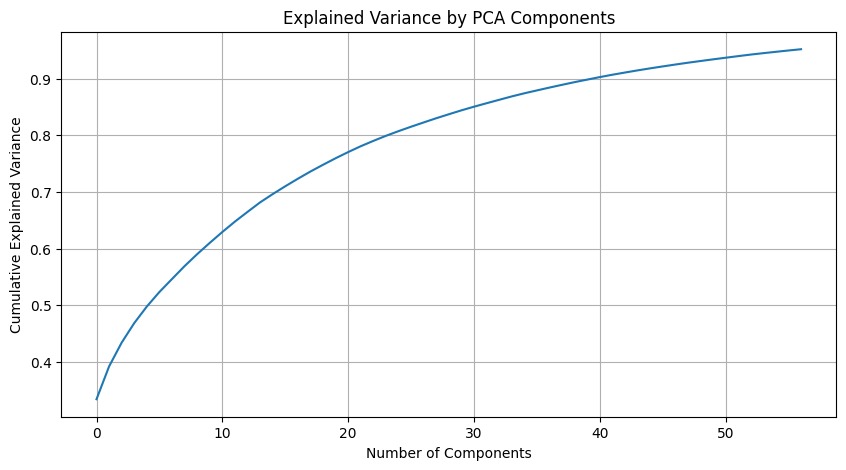

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

data = pd.read_csv('/content/resampled_data.csv')
X = data.drop('Label', axis=1)
y = data['Label']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)


print("Variance explained by each component:", pca.explained_variance_ratio_)
print("Total variance explained:", sum(pca.explained_variance_ratio_))


plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance by PCA Components')
plt.grid(True)
plt.show()

import pandas as pd


df_pca = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(X_pca.shape[1])])
df_pca.to_csv('pca_output.csv', index=False)

**Compare Between PCA and Features that selected by Random Forest**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


data = pd.read_csv('/content/resampled_data.csv')
X_top_features = data[top_features]
X_pca_features = df_pca

y = data['Label']

X_train_top, X_test_top, y_train, y_test = train_test_split(X_top_features, y, test_size=0.2, random_state=42)
X_train_pca, X_test_pca, _, _ = train_test_split(X_pca_features, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_top_scaled = scaler.fit_transform(X_train_top)
X_test_top_scaled = scaler.transform(X_test_top)

X_train_pca_scaled = scaler.fit_transform(X_train_pca)
X_test_pca_scaled = scaler.transform(X_test_pca)

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

model_top = LogisticRegression()
scores_top = cross_val_score(model_top, X_train_top_scaled, y_train, cv=5)
print("Average CV Score with Top Features:", scores_top.mean())

model_pca = LogisticRegression()
scores_pca = cross_val_score(model_pca, X_train_pca_scaled, y_train, cv=5)
print("Average CV Score with PCA Features:", scores_pca.mean())

Average CV Score with Top Features: 0.8481884057971014
Average CV Score with PCA Features: 0.7721014492753622


After applying Random Forest for feature ranking, we manually selected the top 30 features based on their importance scores and domain relevance.


# **Step5:Classification**

**Traditional Classification**

Running GridSearchCV for Random Forest...
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Running GridSearchCV for Gradient Boosting...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Running GridSearchCV for Logistic Regression...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Running GridSearchCV for SVM Linear...
Fitting 5 folds for each of 3 candidates, totalling 15 fits
Running GridSearchCV for SVM Poly...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Running GridSearchCV for SVM RBF...
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Performance Summary:

                 Model  Test Accuracy  Test Precision  Test Recall  \
0        Random Forest       0.833333        0.714286     0.909091   
1    Gradient Boosting       0.800000        0.647059     1.000000   
2  Logistic Regression       0.800000        0.647059     1.000000   
3           SVM Linear       0.833333        0.714286     0.909091   
4             SVM 

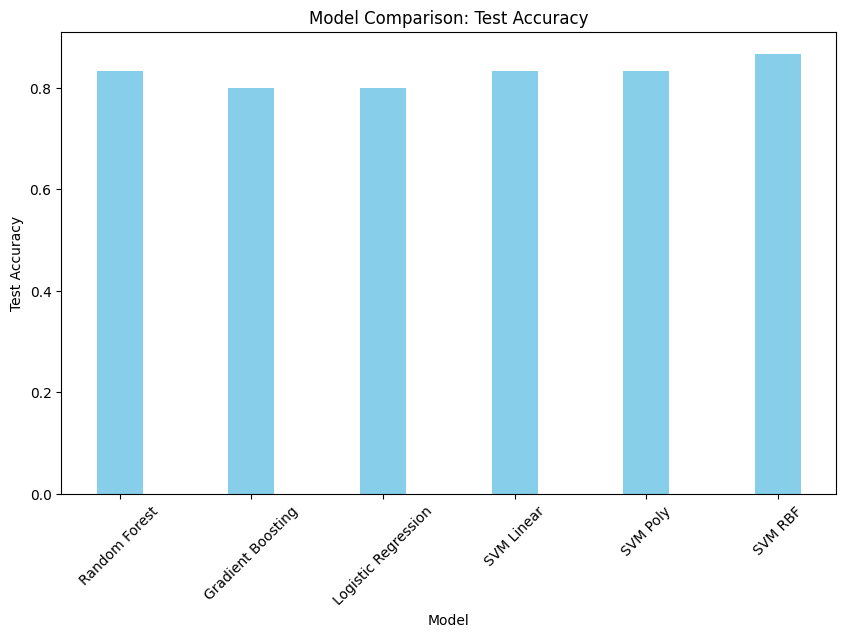

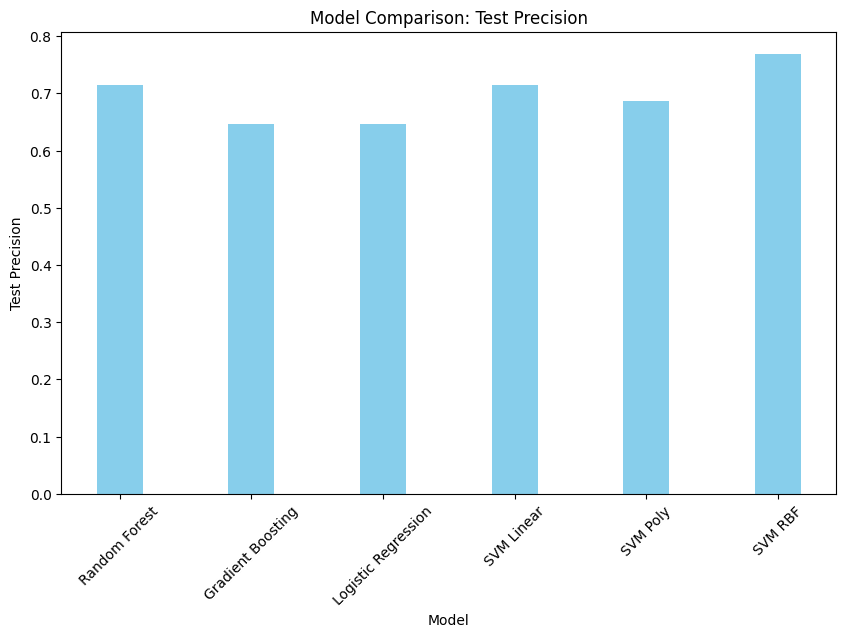

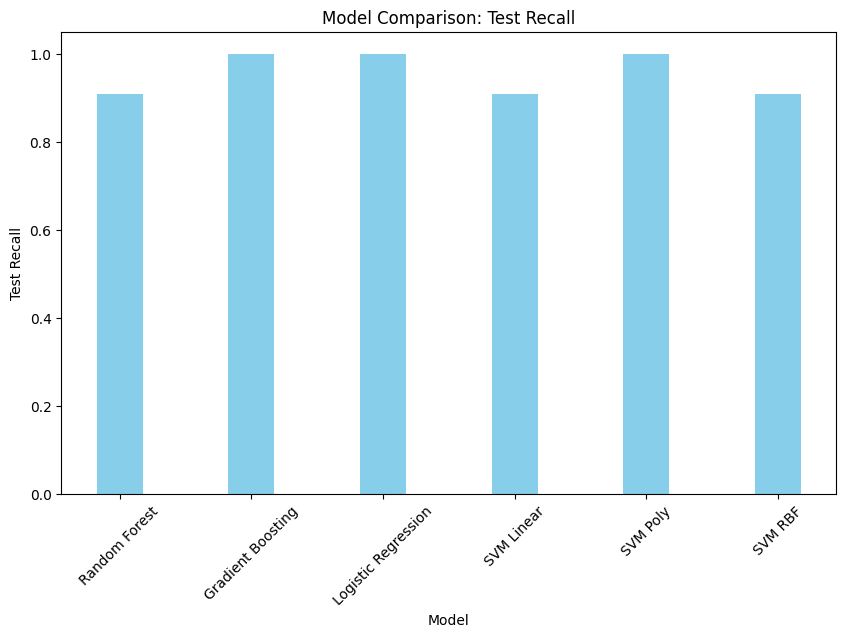

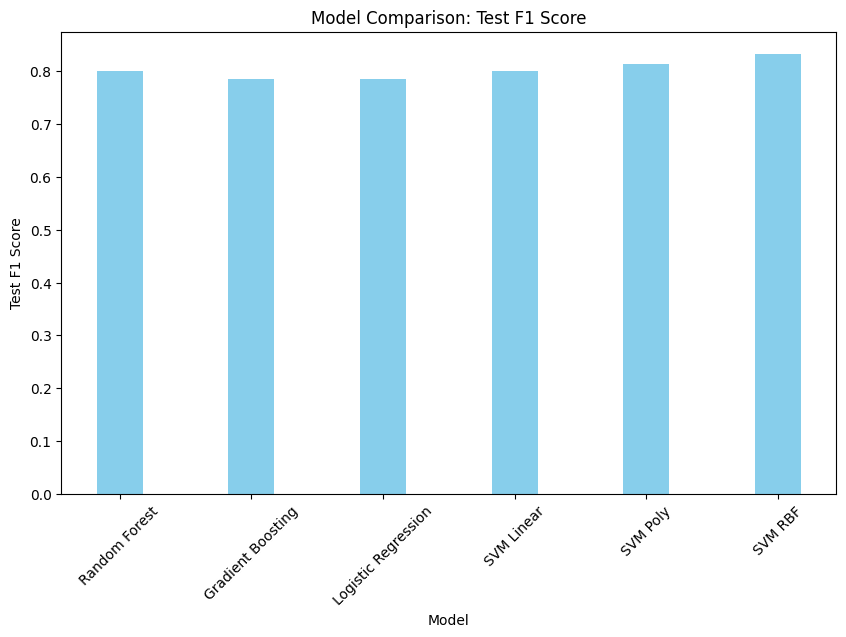

In [ ]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load data
data = pd.read_csv('/content/sample_data/filtered_resampled_data.csv')
X = data.drop('Label', axis=1)
y = data['Label']

# Split data into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Standardizing the features
scaler = StandardScaler()

# Models and parameter grids
pipelines = {
    'Random Forest': Pipeline([('scaler', scaler), ('classifier', RandomForestClassifier(random_state=42))]),
    'Gradient Boosting': Pipeline([('scaler', scaler), ('classifier', GradientBoostingClassifier(random_state=42))]),
    'Logistic Regression': Pipeline([('scaler', scaler), ('classifier', LogisticRegression(random_state=42))]),
    'SVM Linear': Pipeline([('scaler', scaler), ('classifier', SVC(kernel='linear', random_state=42))]),
    'SVM Poly': Pipeline([('scaler', scaler), ('classifier', SVC(kernel='poly', random_state=42))]),
    'SVM RBF': Pipeline([('scaler', scaler), ('classifier', SVC(kernel='rbf', random_state=42))])
}

param_grid = {
    'Random Forest': {'classifier__n_estimators': [50, 100], 'classifier__max_depth': [10, 20, None], 'classifier__min_samples_split': [2, 5, 10]},
    'Gradient Boosting': {'classifier__n_estimators': [100, 200], 'classifier__learning_rate': [0.01, 0.1], 'classifier__max_depth': [3, 5, 7]},
    'Logistic Regression': {'classifier__C': [0.1, 1, 10]},
    'SVM Linear': {'classifier__C': [0.1, 1, 10]},
    'SVM Poly': {'classifier__C': [0.1, 1, 10], 'classifier__degree': [2, 3, 4]},
    'SVM RBF': {'classifier__C': [0.1, 1, 10], 'classifier__gamma': [0.01, 0.1, 1]}
}

# Collecting performance metrics for each model
results = []
# Initialize the best_models dictionary
best_models = {}

for model_name in pipelines.keys():
    print(f"Running GridSearchCV for {model_name}...")
    grid_search = GridSearchCV(pipelines[model_name], param_grid[model_name], cv=5, n_jobs=-1, verbose=2)
    grid_search.fit(X_train, y_train)
    best_models[model_name] = grid_search.best_estimator_

    # Predict on test set
    y_test_pred = grid_search.best_estimator_.predict(X_test)

    # Collect scores for comparison
    results.append({
        'Model': model_name,
        'Test Accuracy': accuracy_score(y_test, y_test_pred),
        'Test Precision': precision_score(y_test, y_test_pred),
        'Test Recall': recall_score(y_test, y_test_pred),
        'Test F1 Score': f1_score(y_test, y_test_pred)
    })

# Convert results to DataFrame for easier visualization
df_results = pd.DataFrame(results)

# Displaying the result in a table format
print("Performance Summary:\n")
print(df_results)

# Plotting bar charts for each metric
metrics = ['Test Accuracy', 'Test Precision', 'Test Recall', 'Test F1 Score']
bar_width = 0.35

# Plot for each metric
for metric in metrics:
    plt.figure(figsize=(10, 6))
    plt.bar(df_results['Model'], df_results[metric], color='skyblue', width=bar_width)
    plt.title(f'Model Comparison: {metric}')
    plt.xlabel('Model')
    plt.ylabel(metric)
    plt.xticks(rotation=45)
    plt.show()

Deep Learning Models

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step - accuracy: 0.4693 - loss: 0.7008 - val_accuracy: 0.7000 - val_loss: 0.6790
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6584 - loss: 0.6808 - val_accuracy: 0.7333 - val_loss: 0.6560
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6889 - loss: 0.6590 - val_accuracy: 0.7000 - val_loss: 0.6315
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.7037 - loss: 0.6373 - val_accuracy: 0.7000 - val_loss: 0.6026
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6821 - loss: 0.6193 - val_accuracy: 0.7000 - val_loss: 0.5754
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6907 - loss: 0.5880 - val_accuracy: 0.7000 - val_loss: 0.5577
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6787 - loss: 0.5698 - val_accuracy: 0.6667 - val_loss: 0.5598
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6907 - loss: 0.5572 - val_accuracy: 0.6667 - val_loss: 0.5595
Epoch 9/50

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 188ms/step - accuracy: 0.4049 - loss: 0.7010 - val_accuracy: 0.6667 - val_loss: 0.6620
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.7077 - loss: 0.6474 - val_accuracy: 0.7000 - val_loss: 0.6228
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.7295 - loss: 0.6031 - val_accuracy: 0.6667 - val_loss: 0.5838
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.7105 - loss: 0.5762 - val_accuracy: 0.7000 - val_loss: 0.5486
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.7144 - loss: 0.5354 - val_accuracy: 0.7000 - val_loss: 0.5318
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.7144 - loss: 0.5115 - val_accuracy: 0.7000 - val_loss: 0.5303
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7178 - loss: 0.5167 - val_accuracy: 0.7000 - val_loss: 0.5202
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.7233 - loss: 0.5086 - val_accuracy: 0.7000 - val_loss: 0.5082
Epoch 9/50

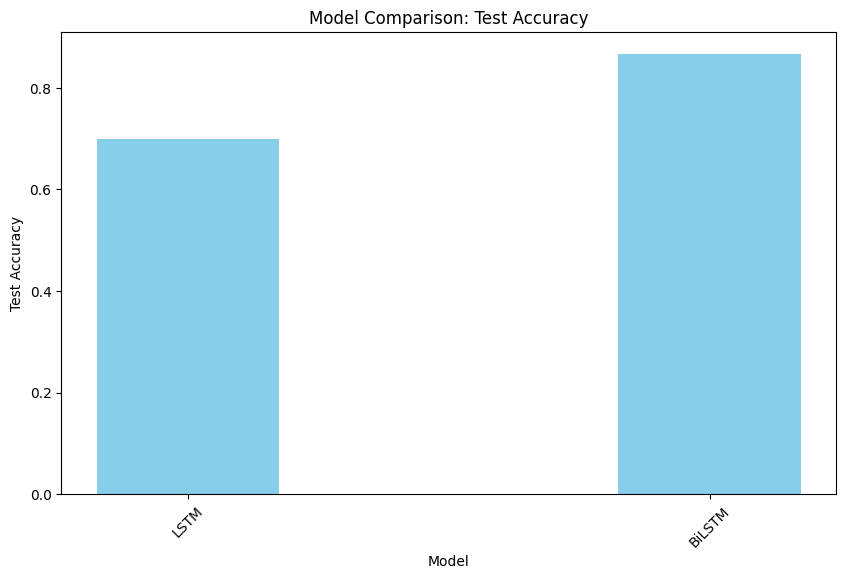

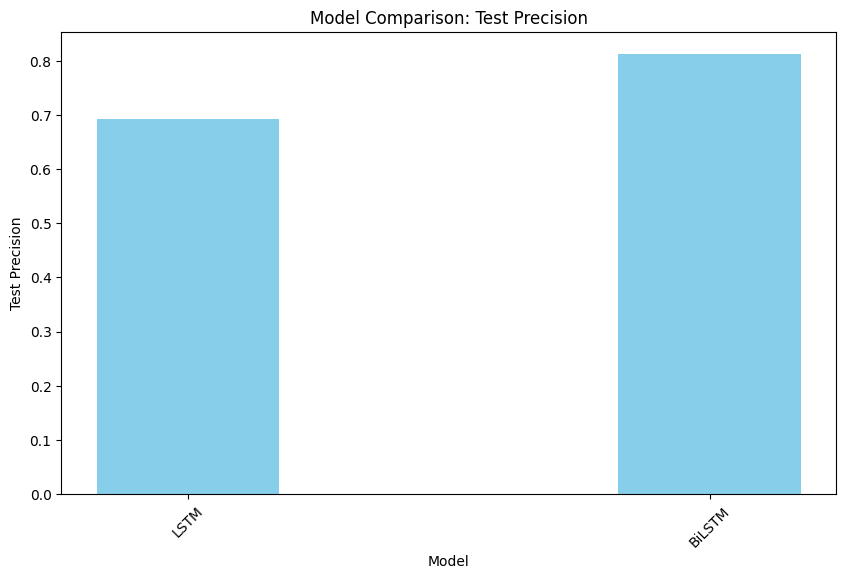

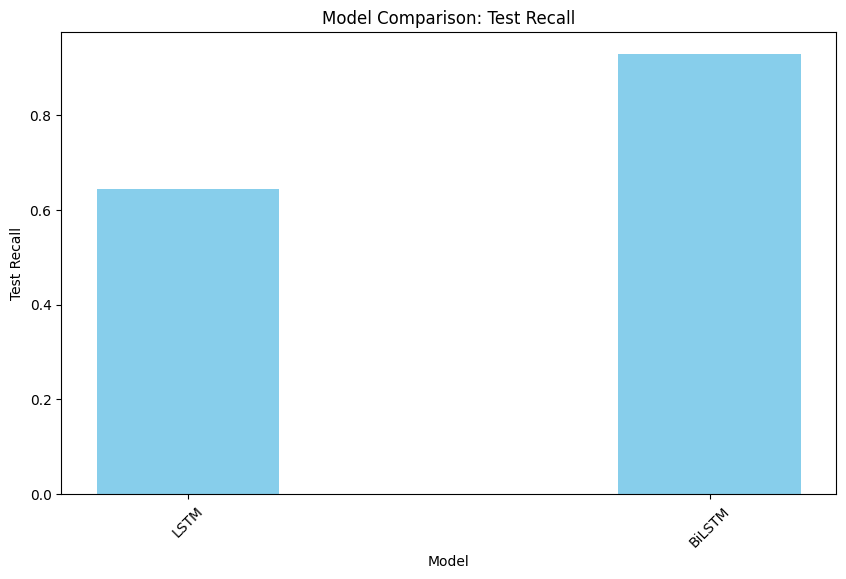

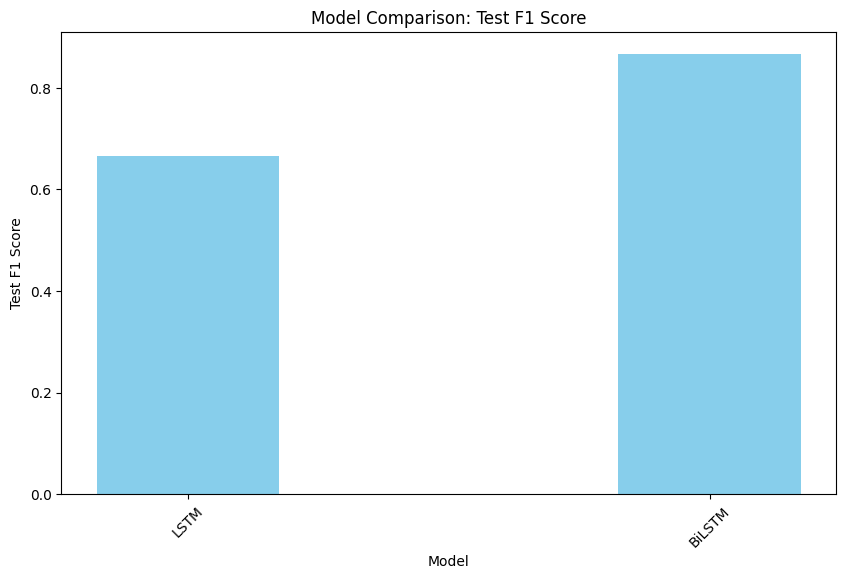

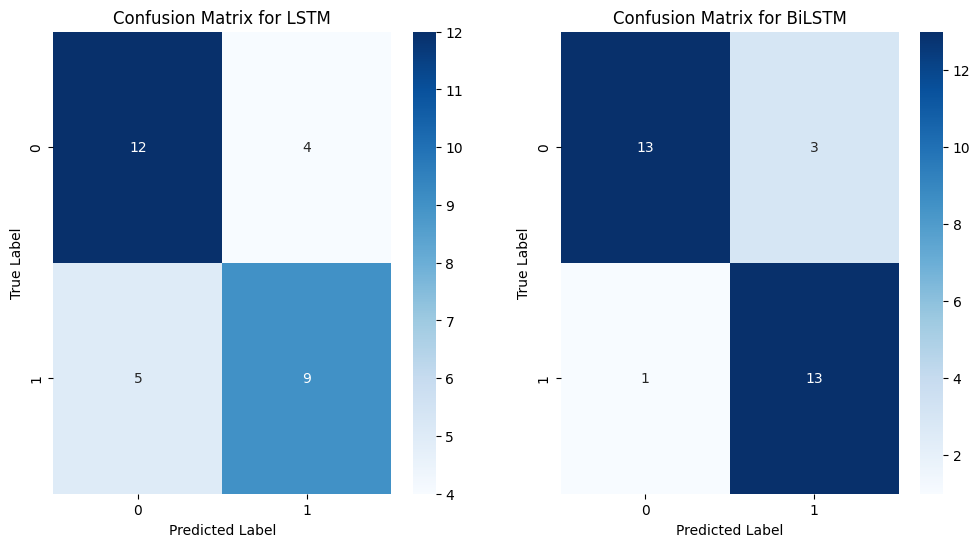

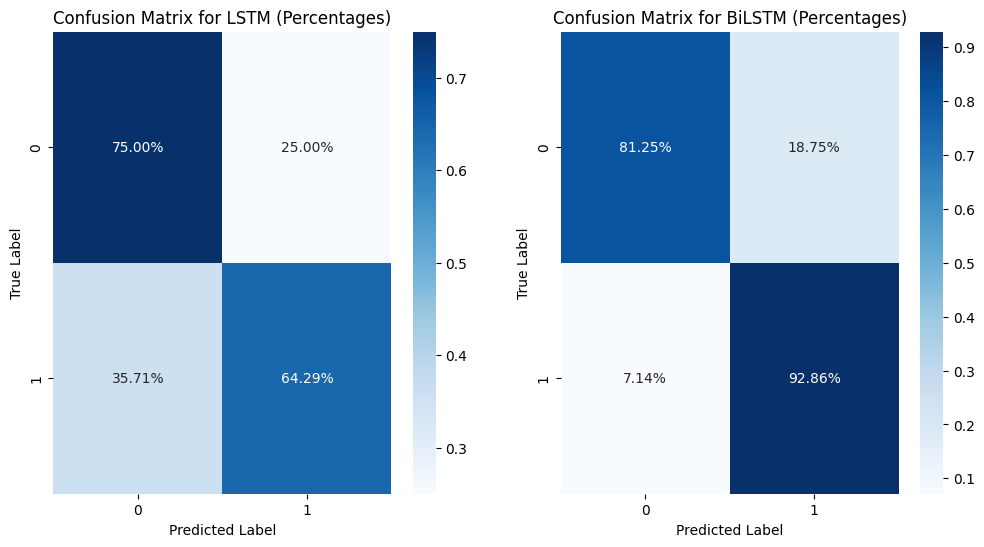

<Figure size 640x480 with 0 Axes>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

# Setting random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load your data
data = pd.read_csv('/content/sample_data/filtered_resampled_data.csv')

# Prepare features and labels
X = data.drop('Label', axis=1)
y = data['Label']

# One-hot encoding of labels (for classification)
y = to_categorical(y)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape data for LSTM [samples, time steps, features]
X_train_scaled = np.expand_dims(X_train_scaled, axis=2)
X_test_scaled = np.expand_dims(X_test_scaled, axis=2)

# Define LSTM model with Dropout and Early Stopping
def build_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(64, input_shape=input_shape, return_sequences=False))
    model.add(Dropout(0.5))  # Dropout to reduce overfitting
    model.add(Dense(32, activation='relu'))
    model.add(Dense(y_train.shape[1], activation='softmax'))  # Use softmax for multi-class classification
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Define biLSTM model with Dropout and Early Stopping
def build_bilstm_model(input_shape):
    model = Sequential()
    model.add(Bidirectional(LSTM(64), input_shape=input_shape))
    model.add(Dropout(0.5))  # Dropout to reduce overfitting
    model.add(Dense(32, activation='relu'))
    model.add(Dense(y_train.shape[1], activation='softmax'))  # Use softmax for multi-class classification
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Callbacks for Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Build and train LSTM model
lstm_model = build_lstm_model((X_train_scaled.shape[1], X_train_scaled.shape[2]))
lstm_history = lstm_model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_data=(X_test_scaled, y_test), callbacks=[early_stopping])

# Build and train biLSTM model
bilstm_model = build_bilstm_model((X_train_scaled.shape[1], X_train_scaled.shape[2]))
bilstm_history = bilstm_model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_data=(X_test_scaled, y_test), callbacks=[early_stopping])

# Evaluate the models on the test set
lstm_test_loss, lstm_test_acc = lstm_model.evaluate(X_test_scaled, y_test)
bilstm_test_loss, bilstm_test_acc = bilstm_model.evaluate(X_test_scaled, y_test)

# Predictions for metrics
y_test_pred_lstm = lstm_model.predict(X_test_scaled)
y_test_pred_bilstm = bilstm_model.predict(X_test_scaled)

# Convert predictions back to label format
y_test_pred_lstm_labels = np.argmax(y_test_pred_lstm, axis=1)
y_test_pred_bilstm_labels = np.argmax(y_test_pred_bilstm, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

# Metrics for LSTM
lstm_acc = accuracy_score(y_test_labels, y_test_pred_lstm_labels)
lstm_prec = precision_score(y_test_labels, y_test_pred_lstm_labels)
lstm_rec = recall_score(y_test_labels, y_test_pred_lstm_labels)
lstm_f1 = f1_score(y_test_labels, y_test_pred_lstm_labels)

# Metrics for BiLSTM
bilstm_acc = accuracy_score(y_test_labels, y_test_pred_bilstm_labels)
bilstm_prec = precision_score(y_test_labels, y_test_pred_bilstm_labels)
bilstm_rec = recall_score(y_test_labels, y_test_pred_bilstm_labels)
bilstm_f1 = f1_score(y_test_labels, y_test_pred_bilstm_labels)

# Create a dataframe to summarize results
df_results = pd.DataFrame({
    'Model': ['LSTM', 'BiLSTM'],
    'Test Accuracy': [lstm_acc, bilstm_acc],
    'Test Precision': [lstm_prec, bilstm_prec],
    'Test Recall': [lstm_rec, bilstm_rec],
    'Test F1 Score': [lstm_f1, bilstm_f1]
})

print(df_results)

# Plotting bar charts for each metric
metrics = ['Test Accuracy', 'Test Precision', 'Test Recall', 'Test F1 Score']
bar_width = 0.35

# Plot for each metric
for metric in metrics:
    plt.figure(figsize=(10, 6))
    plt.bar(df_results['Model'], df_results[metric], color='skyblue', width=bar_width)
    plt.title(f'Model Comparison: {metric}')
    plt.xlabel('Model')
    plt.ylabel(metric)
    plt.xticks(rotation=45)
    plt.show()

# Confusion matrices for LSTM and BiLSTM
conf_matrix_lstm = confusion_matrix(y_test_labels, y_test_pred_lstm_labels)
conf_matrix_bilstm = confusion_matrix(y_test_labels, y_test_pred_bilstm_labels)

# Plot confusion matrices
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
sns.heatmap(conf_matrix_lstm, annot=True, fmt='d', cmap='Blues', ax=axs[0])
axs[0].set_title('Confusion Matrix for LSTM')
axs[0].set_xlabel('Predicted Label')
axs[0].set_ylabel('True Label')

sns.heatmap(conf_matrix_bilstm, annot=True, fmt='d', cmap='Blues', ax=axs[1])
axs[1].set_title('Confusion Matrix for BiLSTM')
axs[1].set_xlabel('Predicted Label')
axs[1].set_ylabel('True Label')

###################################
# Normalize the confusion matrices to percentages
conf_matrix_lstm_norm = conf_matrix_lstm.astype('float') / conf_matrix_lstm.sum(axis=1)[:, np.newaxis]
conf_matrix_bilstm_norm = conf_matrix_bilstm.astype('float') / conf_matrix_bilstm.sum(axis=1)[:, np.newaxis]

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot for LSTM
sns.heatmap(conf_matrix_lstm_norm, annot=True, fmt='.2%', cmap='Blues', ax=axs[0])
axs[0].set_title('Confusion Matrix for LSTM (Percentages)')
axs[0].set_xlabel('Predicted Label')
axs[0].set_ylabel('True Label')

# Plot for BiLSTM
sns.heatmap(conf_matrix_bilstm_norm, annot=True, fmt='.2%', cmap='Blues', ax=axs[1])
axs[1].set_title('Confusion Matrix for BiLSTM (Percentages)')
axs[1].set_xlabel('Predicted Label')
axs[1].set_ylabel('True Label')

plt.show()
#####################################

plt.tight_layout()
plt.show()

In [ ]:
!pip install -q tensorflow seaborn


#**Step6:Evaluation**
AUC-ROC

Epoch 1/50
3/3 - 9s - 3s/step - accuracy: 0.5106 - loss: 0.6854 - val_accuracy: 0.8750 - val_loss: 0.6708
Epoch 2/50
3/3 - 0s - 35ms/step - accuracy: 0.8191 - loss: 0.5745 - val_accuracy: 0.8750 - val_loss: 0.6486
Epoch 3/50
3/3 - 0s - 34ms/step - accuracy: 0.8511 - loss: 0.4864 - val_accuracy: 0.8750 - val_loss: 0.6254
Epoch 4/50
3/3 - 0s - 41ms/step - accuracy: 0.8404 - loss: 0.4347 - val_accuracy: 0.8750 - val_loss: 0.6011
Epoch 5/50
3/3 - 0s - 43ms/step - accuracy: 0.8511 - loss: 0.3938 - val_accuracy: 0.8750 - val_loss: 0.5777
Epoch 6/50
3/3 - 0s - 51ms/step - accuracy: 0.8830 - loss: 0.3526 - val_accuracy: 0.8750 - val_loss: 0.5555
Epoch 7/50
3/3 - 0s - 35ms/step - accuracy: 0.8830 - loss: 0.3154 - val_accuracy: 0.8750 - val_loss: 0.5347
Epoch 8/50
3/3 - 0s - 35ms/step - accuracy: 0.8723 - loss: 0.2965 - val_accuracy: 0.8750 - val_loss: 0.5167
Epoch 9/50
3/3 - 0s - 47ms/step - accuracy: 0.8936 - loss: 0.2756 - val_accuracy: 0.8333 - val_loss: 0.5004
Epoch 10/50
3/3 - 0s - 36ms/st

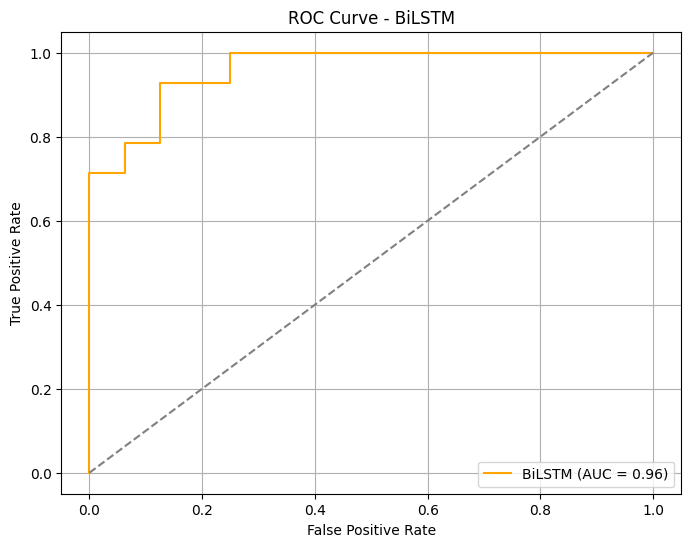

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam

# Setting seed
np.random.seed(42)
import tensorflow as tf
tf.random.set_seed(42)

# Load data
data = pd.read_csv('/content/sample_data/filtered_resampled_data.csv')
X = data.drop('Label', axis=1)
y = data['Label']

# One-hot encoding for binary classification
y_cat = to_categorical(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size=0.2, random_state=42)

# Standardization
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape for LSTM input: [samples, timesteps, features]
X_train_scaled = np.expand_dims(X_train_scaled, axis=1)
X_test_scaled = np.expand_dims(X_test_scaled, axis=1)

# Class weights (in case of imbalance)
y_train_labels = np.argmax(y_train, axis=1)
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_labels), y=y_train_labels)
class_weights_dict = dict(enumerate(class_weights))

# Build BiLSTM model
def build_optimized_bilstm(input_shape, num_classes):
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Bidirectional(LSTM(64, return_sequences=True)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))
    model.add(Bidirectional(LSTM(32)))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Initialize model
input_shape = (X_train_scaled.shape[1], X_train_scaled.shape[2])
num_classes = y_train.shape[1]
model = build_optimized_bilstm(input_shape, num_classes)

# Early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Training
history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping],
    class_weight=class_weights_dict,
    verbose=2
)

# Evaluation
y_pred_prob = model.predict(X_test_scaled)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

# Metrics
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"BiLSTM Accuracy:  {acc:.4f}")
print(f"BiLSTM Precision: {prec:.4f}")
print(f"BiLSTM Recall:    {rec:.4f}")
print(f"BiLSTM F1-Score:  {f1:.4f}")


# ROC-AUC
fpr, tpr, _ = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='orange', label=f'BiLSTM (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - BiLSTM')
plt.legend()
plt.grid()
plt.show()
